# Data collection

## ClaimReview

In [101]:
import requests
import json
from glob import glob
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import time

In [40]:
def getReviews(offset=0):
    params = {
        'hl': '', # the language to search
        'num_results': 1000,
        'query': 'list:recent',
        'force': 'false',
        'offset': offset
    }
    headers = {
        'dnt': '1',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-GB,en;q=0.9,it-IT;q=0.8,it;q=0.7,en-US;q=0.6',
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36',
        'accept': 'application/json, text/plain, */*',
        'referer': 'https://toolbox.google.com/factcheck/explorer/search/list:recent;hl=en;gl=',
        'authority': 'toolbox.google.com',
        'cookie': os.environ.get('GOOGLE_FACTCHECK_EXPLORER_COOKIE')  # access authorization cookie data
    }
    response = requests.get('https://toolbox.google.com/factcheck/api/search', params=params, headers=headers)

    if response.status_code != 200:
        raise ValueError(response.status_code)

    content = json.loads(response.text[5:])[0][1:3]
    today = datetime.now().strftime("%B %d, %Y")
    path = "/Users/anders1991/Github/FactMap/Data/claimreviews/raw/"+today+"/"
    filename = "raw_{0}.json".format(offset)
    
    if not os.path.isdir(path):
        os.makedirs(path)
    with open(path + filename, 'w') as f:
        json.dump(content, f, indent=2)
    
    return content

In [41]:
def collect():
    offset = 0
    claims = []
    tags = []
    
    while True:
        print('offset', offset)
        content = getReviews(offset=offset)
        if not content[0]:
            break
        offset += len(content[0])
        claims.append(content[0])
        tags.append(content[1])

    return claims, tags

Collect raw data:

In [42]:
# raw = collect()

Load collected raw data:

In [57]:
# today = datetime.now().strftime("%B %d, %Y")
path = "/Users/anders1991/Github/FactMap/Data/claimreviews/raw/March 5, 2019/" # "+today+"/"
print(path)
raw_paths = glob(path+"*.json")

raw = []
for path in raw_paths:
    with open(path) as f:  
        raw.append(json.load(f))
        
print('batches:', len(raw))  # num batches

/Users/anders1991/Github/FactMap/Data/claimreviews/raw/March 5, 2019/
batches: 33


In [58]:
raw_claims = [c for batch in raw for c in batch[0][1]]
raw_tags = {c[0]: c[1] for batch in raw for c in batch[0][2]}

print("Num claims:\t", len(raw_claims))
print("Num tags:\t", len(raw_tags))

Num claims:	 31269
Num tags:	 20768


/m/ tags are Freebase identifiers  
/g/ tags are Google identifiers  
/t/ tags are ?

Parse data to ClaimReviews:

In [62]:
def parseReviews(reviews, tagdict):
    results = []
    for idx, r in enumerate(reviews):
        try:
            claimReview = {
                'reviewUrl': r[0][3][0][1],
                'claimReviewed': r[0][0],
                'lang': r[0][3][0][6],
                'countries': r[0][3][0][7],
                'claimReviewed_en': r[0][11] if len(r[0]) > 11 else None,
                'claimDate': r[0][2] if len(r[0]) > 2 else None,
                'reviewDate': r[0][3][0][2] if len(r[0][3][0]) > 2 else None,
                'reviewAuthor': {
                    "name": r[0][3][0][0][0],  # review author
                    "authorURL": r[0][3][0][0][1]
                },
                'reviewRating': {
                    'ratingValue': r[0][3][0][9][0] if (len(r[0][3][0]) > 9 and r[0][3][0][9] and len(r[0][3][0][9])) else -1,
                    'worstRating': r[0][3][0][9][1] if (len(r[0][3][0]) > 9 and r[0][3][0][9] and len(r[0][3][0][9])) else -1,
                    'bestRating': r[0][3][0][9][2] if  (len(r[0][3][0]) > 9 and r[0][3][0][9] and len(r[0][3][0][9])) else -1,
                    'alternateName': r[0][3][0][3]
                },
                'claimAuthor': {
                    'name': r[0][1][0],  # claim author
                    'claimURL': r[0][4][0][1] if len(r[0][4]) else None
                } if len(r[0][1]) else {},
                'tagsRaw': [{'keyword': tag[0], 'probability': tag[1]} for tag in r[0][8] if len(tag) == 2],
                'tagsNamed': [{'keyword': raw_tags[tag[0]], 'probability': tag[1]} for tag in r[0][8] if (tag[0] in raw_tags) and (len(tag) == 2)],
                'reviewTitle': r[0][3][0][8]
            }
            results.append(claimReview)
        except IndexError as e:
            print(idx)
            print(json.dumps(r))
            raise(e)
    return results

In [63]:
claims = parseReviews(raw_claims, raw_tags)
len(claims)

31269

Save parsed ClaimReviews to json:

In [65]:
path = "/Users/anders1991/Github/FactMap/Data/claimreviews/claims.json"

In [66]:
# with open(path, 'w') as f:
#     f.write('\n'.join(json.dumps(c) for c in claims))

Load parsed ClaimReviews:

In [68]:
paths = glob("/Users/anders1991/Github/FactMap/Data/claimreviews/*.json")
latest = max(paths, key=os.path.getctime)
print('Latest file:', latest)

Latest file: /Users/anders1991/Github/FactMap/Data/claimreviews/claims.json


In [2]:
# with open(latest, 'r') as fp:
#     claims = json.load(fp)

# print(len(claims))

---

Collect new claims:

In [69]:
raw = collect()
len(raw)

offset 0
offset 1000
offset 2000
offset 3000
offset 4000
offset 5000
offset 6000
offset 7000
offset 8000
offset 9000
offset 10000
offset 11000
offset 12000
offset 13000
offset 14000
offset 15000
offset 16000
offset 17000
offset 18000
offset 19000
offset 20000
offset 21000
offset 22000
offset 23000
offset 24000
offset 25000
offset 26000
offset 27000
offset 28000
offset 29000
offset 29028


2

In [70]:
raw_claims = [c for b in raw[0] for c in b]
raw_tags = {r[0]: r[1] for b in raw[1] for r in b if len(r) == 2}
        
print(len(raw_claims))
print(len(raw_tags))

29028
18132


In [71]:
claims_new = parseReviews(raw_claims, raw_tags)
len(claims_new)

29028

In [72]:
hashes = set()
allclaims = []

for c in (claims + claims_new):
    hsh = hash(str(c))
    if hsh not in hashes:
        allclaims.append(c)
        hashes.add(hsh)
        
len(allclaims)

60074

In [73]:
claims = allclaims

Save combined claims to file:

In [74]:
today = datetime.now().strftime("%b-%d-%Y")
path = "/Users/anders1991/Github/FactMap/Data/claimreviews/claims_"

with open(path + today + ".json", 'w') as f:
    f.write('\n'.join(json.dumps(c) for c in claims))

Reload combined claims from file:

In [54]:
path = glob("/Users/anders1991/Github/FactMap/Data/claimreviews/claims_*")

claims = []
with open(path[0], 'r') as f:
    for line in f:
         claims.append(json.loads(line))
            
len(claims)

59747

---

## Summary statistics

Amount of ClaimReviews with source URLs:

In [77]:
claims[0]

{'claimAuthor': {'claimURL': None, 'name': 'Amazon'},
 'claimDate': 1511481600,
 'claimReviewed': '“i salari dei dipendenti di Amazon sono i più alti del settore della logistica',
 'claimReviewed_en': '"The wages of Amazon employees are the highest in the logistics sector',
 'countries': ['us', 'it'],
 'lang': 'it',
 'reviewAuthor': {'authorURL': 'agi.it', 'name': 'Agi'},
 'reviewDate': 1511884336,
 'reviewRating': {'alternateName': 'Vero',
  'bestRating': 5,
  'ratingValue': 1,
  'worstRating': 1},
 'reviewTitle': 'Quanto guadagna effettivamente un magazziniere di Amazon?',
 'reviewUrl': 'https://www.agi.it/fact-checking/amazon_black_friday_sciopero_stipendio_fact_checking-3159937/news/2017-11-25/',
 'tagsNamed': [{'keyword': 'Salary', 'probability': 0.7125},
  {'keyword': 'Amazon.com', 'probability': 0.7072},
  {'keyword': 'Employee', 'probability': 0.3023},
  {'keyword': 'Logistics', 'probability': 0.218}],
 'tagsRaw': [{'keyword': '/m/02w88k', 'probability': 0.7125},
  {'keyword': 

In [79]:
urls = []
for i, c in enumerate(claims):
    try:
        if c['claimAuthor']['claimURL']:
            urls.append(c)
    except:
        None

print('Claims in total:\t', len(claims))
print('Claims w/ source URLs:\t', len(urls))
print('% of claims w/ URLs:\t', round(len(urls)/len(claims)*100, 1))

Claims in total:	 60074
Claims w/ source URLs:	 12282
% of claims w/ URLs:	 20.4


Number of unique topics found in ClaimReviews:

In [89]:
tpc = dict()

for c in claims:
    for t in list(c['tagsNamed']):
        if t['keyword'] in tpc.keys():
            tpc[t['keyword']] += 1
        else:
            tpc[t['keyword']] = 1

print('Num topics found in ClaimReviews:\t', len(tpc))

Num topics found in ClaimReviews:	 21668


In [91]:
top = sorted(tpc, key=tpc.get, reverse=True)[:10]

for c in top:
    print(c, tpc[c])

Donald Trump 2444
United States of America 1977
Photograph 1737
Government 1735
Video 1657
Voting 1427
United States 1383
Russia 1347
Interview 1307
Election 1257


Number of distinct countries:

In [92]:
countries = dict()

for c in claims:
    for cntry in c['countries']:
        if cntry in countries.keys():
            countries[cntry] += 1
        else:
            countries[cntry] = 1
#         countries.add(cntry)
        
print(len(countries))

222


In [93]:
top = sorted(countries, key=countries.get, reverse=True)[:10]

for c in top:
    print(c, countries[c])

us 25503
br 9453
in 6132
fr 3292
gb 3286
ar 2452
tr 2290
it 2273
ru 2267
de 1805


Number of distinct languages:

In [94]:
langs = dict()

for c in claims:
    lang = c['lang']
    if lang in langs.keys():
        langs[lang] += 1
    else:
        langs[lang] = 1
        
print(len(langs))

37


In [95]:
top = sorted(langs, key=langs.get, reverse=True)[:10]

for c in top:
    print(c, langs[c])

en 29572
pt 5408
pt-pt 4781
es 3838
id 2348
it 1990
tr 1980
hi 1624
fr 1421
sr 1341


Temporal distribution of claims:

In [99]:
x = np.histogram([c['claimDate'] for c in claims if c['claimDate'] is not None], bins=1000)

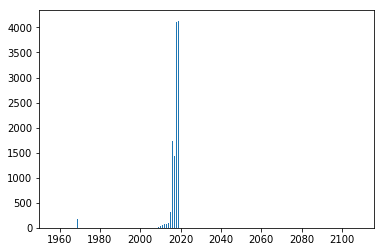

In [103]:
plt.bar([int(datetime.fromtimestamp(q).strftime('%Y')) for q in x[1][:-1]], x[0])
plt.show()

Temporal distribution of reviews:

In [105]:
x = np.histogram([c['reviewDate'] for c in claims if c['reviewDate'] is not None], bins=1000)

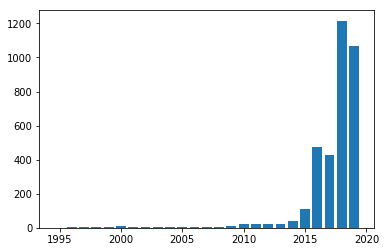

In [106]:
plt.bar([int(datetime.fromtimestamp(q).strftime('%Y')) for q in x[1][:-1]], x[0])
plt.show()

~95% of data is from 2015 onwards!

---

# Collecting reddit data

In [547]:
def getSubmissions(after=1420070400):
    params = {
        'fields': ['id', 'created_utc', 'retrieved_on', 'subreddit_id', 'domain', 'author', 'title', 'subreddit', 'url',
                   'score', 'num_comments', 'subreddit_type', 'subreddit_subscribers'],
        'sort': 'asc',
        'is_self': False,
        'after': after,  # Jan 1, 2015: 00:00:00
        'size': '500'
    }

    response = requests.get('https://api.pushshift.io/reddit/search/submission/', params=params)

    if response.status_code != 200:
        raise ValueError(response.status_code)

    data = json.loads(response.text)['data']

    return data

In [546]:
def collectSubmissions(after=1420070400):
    after = after
    num = 0
    submissions = []
    requests_per_minute = 180
    requests = 0
    start_time = time.time()
    print('Initiating...')

    while True:
        print('Num:', num)
        time_diff = time.time() - start_time

        if requests < requests_per_minute and time_diff < 60:
            requests += 1
            data = getSubmissions(after=after)

            if not data[0]:
                break

            num += len(data)
            after = data[-1]['created_utc']
            submissions.append(data)

            if num > 2000000 or data[0] is None:  # dump to file if >2M submissions
                path = "/Users/anders1991/Github/FactMap/Data/reddit/raw/"
                filename = "raw_{0}.json".format(after)

                if not os.path.isdir(path):
                    os.makedirs(path)
                with open(path + filename, 'w') as f:
                    json.dump(submissions, f, indent=2)

                submissions = []
                num = 0
        elif time_diff >= 60:
            start_time = time.time()
            requests = 0
        else:
            print('Waiting', 60-time_diff, 'seconds...')
            time.sleep(60-time_diff)

            start_time = time.time()
            requests = 0

    print('Finished!')

    return submissions

In [583]:
# out = collectSubmissions()

Takes too long to download via API!

Downloaded via Google BigQuery instead.

---